https://github.com/asadisaghar/PdM-C-MAPSS/tree/master/play

# # Preprocessing

In [72]:
import sys
import os.path
from math import *
import numpy as np
import pandas as pd
import sklearn.preprocessing
import sklearn.decomposition
import sklearn.cross_decomposition
import sklearn.neighbors
import sklearn.model_selection
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
current_palette_4 = sns.color_palette("hls", 4)
sns.set_palette(current_palette_4)
import preprocessing_tools as tools
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)
data_path = 'data'
if not os.path.exists(data_path):
    os.mkdir(data_path)
plot_path = 'plots'
if not os.path.exists(plot_path):
    os.mkdir(plot_path)

In [73]:
## Settings - Feel free to play!

## The provided training and test set are covering different ranges of RUL (in unit iof cycles), 

## so let's merge them and see how the model learns the behaviours then
merge_data = True
sn = 3 #Different data sets (1 to 4)
n_classes = 4 #number of classes to split RULs into

# How to split the data
train_share = 0.6
test_share = 0.2
validate_share = 0.2
setnumber = 'FD00'+str(sn)

# number of PCA components
nc = 21

In [74]:
#Training set
train = tools.read_set(data_path, setnumber, 'train')
cat_train, scale_train = tools.find_col_types(train)

#Test set
test = tools.read_set(data_path, setnumber, 'test')
cat_test, scale_test = tools.find_col_types(test)

#Labels
label = pd.read_csv(os.path.join(data_path, 'RUL_'+setnumber+'.txt'), header=None)
label.reset_index(level=[0], inplace=True)
label.columns = ['id', 'RUL']
label['id'] = label['id'] + 1  #index is 0-bound but part_ids are 1-bound

#Add labels
train = tools.calculate_train_RUL(train)
test = tools.calculate_test_RUL(test, label)

#Make all values float
train = train.astype('float64')
test = test.astype('float64')

In [75]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24720 entries, 0 to 24719
Data columns (total 27 columns):
id          24720 non-null float64
cycle       24720 non-null float64
setting1    24720 non-null float64
setting2    24720 non-null float64
setting3    24720 non-null float64
s1          24720 non-null float64
s2          24720 non-null float64
s3          24720 non-null float64
s4          24720 non-null float64
s5          24720 non-null float64
s6          24720 non-null float64
s7          24720 non-null float64
s8          24720 non-null float64
s9          24720 non-null float64
s10         24720 non-null float64
s11         24720 non-null float64
s12         24720 non-null float64
s13         24720 non-null float64
s14         24720 non-null float64
s15         24720 non-null float64
s16         24720 non-null float64
s17         24720 non-null float64
s18         24720 non-null float64
s19         24720 non-null float64
s20         24720 non-null float64
s21         2472

In [76]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16596 entries, 0 to 16595
Data columns (total 27 columns):
id          16596 non-null float64
cycle       16596 non-null float64
setting1    16596 non-null float64
setting2    16596 non-null float64
setting3    16596 non-null float64
s1          16596 non-null float64
s2          16596 non-null float64
s3          16596 non-null float64
s4          16596 non-null float64
s5          16596 non-null float64
s6          16596 non-null float64
s7          16596 non-null float64
s8          16596 non-null float64
s9          16596 non-null float64
s10         16596 non-null float64
s11         16596 non-null float64
s12         16596 non-null float64
s13         16596 non-null float64
s14         16596 non-null float64
s15         16596 non-null float64
s16         16596 non-null float64
s17         16596 non-null float64
s18         16596 non-null float64
s19         16596 non-null float64
s20         16596 non-null float64
s21         1659

In [77]:
# Add training and test set to form a full set which is then used for more RUL range coverage
# First, let's fix the problem of "id"s
last_train_id = train.id.max()
test.id = test['id'].map(lambda x: x+last_train_id)
# Then add them all to make the full dataset
full = pd.concat([train, test], ignore_index=True)
# Lastly, we split the full dataset into train, test and validation sets (by id)
full_ids = full.id.unique()

train_len = int(floor(len(full_ids)*train_share))
test_len = int(floor(len(full_ids)*test_share))

train_ids = np.random.choice(full_ids, size=train_len, replace=False)
test_validate_ids = np.setdiff1d(full_ids, train_ids)
test_ids = np.random.choice(test_validate_ids, size=test_len, replace=False)
validate_ids = np.setdiff1d(test_validate_ids, test_ids)

In [79]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41316 entries, 0 to 41315
Data columns (total 27 columns):
id          41316 non-null float64
cycle       41316 non-null float64
setting1    41316 non-null float64
setting2    41316 non-null float64
setting3    41316 non-null float64
s1          41316 non-null float64
s2          41316 non-null float64
s3          41316 non-null float64
s4          41316 non-null float64
s5          41316 non-null float64
s6          41316 non-null float64
s7          41316 non-null float64
s8          41316 non-null float64
s9          41316 non-null float64
s10         41316 non-null float64
s11         41316 non-null float64
s12         41316 non-null float64
s13         41316 non-null float64
s14         41316 non-null float64
s15         41316 non-null float64
s16         41316 non-null float64
s17         41316 non-null float64
s18         41316 non-null float64
s19         41316 non-null float64
s20         41316 non-null float64
s21         4131

In [80]:
if merge_data:
    del train, test
    train = full.loc[full.id.isin(train_ids)]
    test = full.loc[full.id.isin(test_ids)]
    validate = full.loc[full.id.isin(validate_ids)]
    train.reset_index(drop=True, inplace=True)
    test.reset_index(drop=True, inplace=True)
    validate.reset_index(drop=True, inplace=True)
else:
    # split test set into test and validation sets
    msk = np.random.rand(len(test)) < 0.5
    validate = test[~msk].reset_index(drop=True)
    test = test[msk].reset_index(drop=True)
    
#Save intermediate file
if merge_data:
    train.to_csv(os.path.join(data_path, 'train_'+setnumber+'_merge.csv'), index=False)
    test.to_csv(os.path.join(data_path, 'test_'+setnumber+'_merge.csv'), index=False)
    full.to_csv(os.path.join(data_path, 'full_'+setnumber+'_merge.csv'), index=False)
    validate.to_csv(os.path.join(data_path, 'validate_'+setnumber+'_merge.csv'), index=False)
else:
    train.to_csv(os.path.join(data_path, 'train_'+setnumber+'.csv'), index=False)
    test.to_csv(os.path.join(data_path, 'test_'+setnumber+'.csv'), index=False)
    full.to_csv(os.path.join(data_path, 'full_'+setnumber+'.csv'), index=False)
    validate.to_csv(os.path.join(data_path, 'validate_'+setnumber+'.csv'), index=False)

In [81]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24906 entries, 0 to 24905
Data columns (total 27 columns):
id          24906 non-null float64
cycle       24906 non-null float64
setting1    24906 non-null float64
setting2    24906 non-null float64
setting3    24906 non-null float64
s1          24906 non-null float64
s2          24906 non-null float64
s3          24906 non-null float64
s4          24906 non-null float64
s5          24906 non-null float64
s6          24906 non-null float64
s7          24906 non-null float64
s8          24906 non-null float64
s9          24906 non-null float64
s10         24906 non-null float64
s11         24906 non-null float64
s12         24906 non-null float64
s13         24906 non-null float64
s14         24906 non-null float64
s15         24906 non-null float64
s16         24906 non-null float64
s17         24906 non-null float64
s18         24906 non-null float64
s19         24906 non-null float64
s20         24906 non-null float64
s21         2490

In [82]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8116 entries, 0 to 8115
Data columns (total 27 columns):
id          8116 non-null float64
cycle       8116 non-null float64
setting1    8116 non-null float64
setting2    8116 non-null float64
setting3    8116 non-null float64
s1          8116 non-null float64
s2          8116 non-null float64
s3          8116 non-null float64
s4          8116 non-null float64
s5          8116 non-null float64
s6          8116 non-null float64
s7          8116 non-null float64
s8          8116 non-null float64
s9          8116 non-null float64
s10         8116 non-null float64
s11         8116 non-null float64
s12         8116 non-null float64
s13         8116 non-null float64
s14         8116 non-null float64
s15         8116 non-null float64
s16         8116 non-null float64
s17         8116 non-null float64
s18         8116 non-null float64
s19         8116 non-null float64
s20         8116 non-null float64
s21         8116 non-null float64
RUL      

In [83]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41316 entries, 0 to 41315
Data columns (total 27 columns):
id          41316 non-null float64
cycle       41316 non-null float64
setting1    41316 non-null float64
setting2    41316 non-null float64
setting3    41316 non-null float64
s1          41316 non-null float64
s2          41316 non-null float64
s3          41316 non-null float64
s4          41316 non-null float64
s5          41316 non-null float64
s6          41316 non-null float64
s7          41316 non-null float64
s8          41316 non-null float64
s9          41316 non-null float64
s10         41316 non-null float64
s11         41316 non-null float64
s12         41316 non-null float64
s13         41316 non-null float64
s14         41316 non-null float64
s15         41316 non-null float64
s16         41316 non-null float64
s17         41316 non-null float64
s18         41316 non-null float64
s19         41316 non-null float64
s20         41316 non-null float64
s21         4131

In [84]:
validate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8294 entries, 0 to 8293
Data columns (total 27 columns):
id          8294 non-null float64
cycle       8294 non-null float64
setting1    8294 non-null float64
setting2    8294 non-null float64
setting3    8294 non-null float64
s1          8294 non-null float64
s2          8294 non-null float64
s3          8294 non-null float64
s4          8294 non-null float64
s5          8294 non-null float64
s6          8294 non-null float64
s7          8294 non-null float64
s8          8294 non-null float64
s9          8294 non-null float64
s10         8294 non-null float64
s11         8294 non-null float64
s12         8294 non-null float64
s13         8294 non-null float64
s14         8294 non-null float64
s15         8294 non-null float64
s16         8294 non-null float64
s17         8294 non-null float64
s18         8294 non-null float64
s19         8294 non-null float64
s20         8294 non-null float64
s21         8294 non-null float64
RUL      

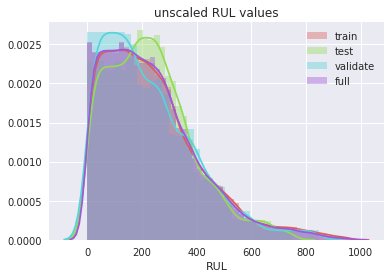

In [85]:
plt.figure()
sns.distplot(train.RUL, label='train')
sns.distplot(test.RUL, label='test')
sns.distplot(validate.RUL, label='validate')
sns.distplot(full.RUL, label='full')
plt.legend()
plt.title('unscaled RUL values')
if merge_data:
    plt.savefig(os.path.join(plot_path, setnumber+'_RULs_unscaled_merge.png'))
else:
    plt.savefig(os.path.join(plot_path, setnumber+'_RULs_unscaled.png'))
plt.show()

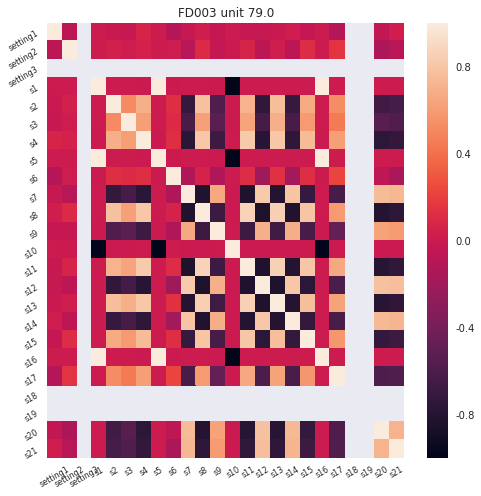

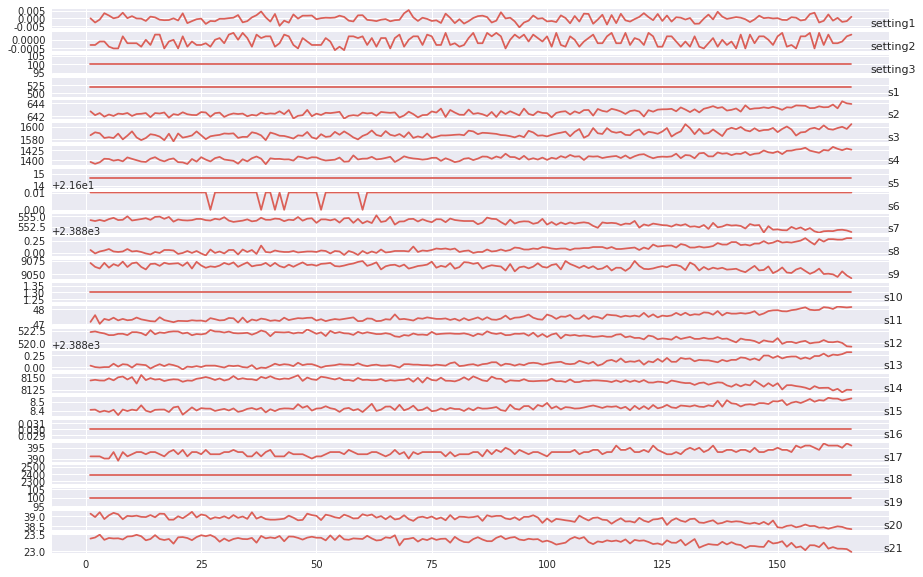

In [29]:
## plot correlations for unit i
i = np.random.choice(train.id)
df = train.loc[train.id==i].sort_values(by='cycle')
tools.plot_correlations(df, drop_cols=['id', 'cycle', 'RUL'], 
                      title='%s unit %s'%(setnumber, i), plot_path=plot_path, plot_name=setnumber)
tools.plot_all_measurements(df, plot_path='plots', plot_name='raw_sequences.png')

In [30]:
## SCALE DATA
#normalize features (using MinMaxScaler)
train_scalables = train[train.columns.difference(['id', 'cycle', 'status'])].values
test_scalables = test[test.columns.difference(['id', 'cycle', 'status'])].values
validate_scalables = validate[validate.columns.difference(['id', 'cycle', 'status'])].values
full_scalables = full[full.columns.difference(['id', 'cycle', 'status'])].values

scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0,1)).fit(train_scalables)

full_values = scaler.transform(full_scalables)
train_values = scaler.transform(train_scalables)
test_values = scaler.transform(test_scalables)
validate_values = scaler.transform(validate_scalables)
    
train[train.columns.difference(['id', 'cycle'])] = train_values
test[test.columns.difference(['id', 'cycle'])] = test_values
validate[validate.columns.difference(['id', 'cycle'])] = validate_values
full[full.columns.difference(['id', 'cycle'])] = full_values

In [32]:
# Bins for scaled RUL values corresponding to urgent, short, medium, long
RUL_min = full.RUL.min()
RUL_max = full.RUL.max()

bins = np.linspace(RUL_min-(RUL_max-RUL_min)/n_classes, RUL_max+RUL_min, n_classes+1)
status_labels = ['RUL%d'%x for x in range(n_classes)]

# bin RUL values
full['status'] = pd.cut(full['RUL'], bins, labels=status_labels)
train['status'] = pd.cut(train['RUL'], bins, labels=status_labels)
test['status'] = pd.cut(test['RUL'], bins, labels=status_labels)
validate['status'] = pd.cut(validate['RUL'], bins, labels=status_labels)

print (bins)
print (status_labels)

[-0.25    0.0625  0.375   0.6875  1.    ]
['RUL0', 'RUL1', 'RUL2', 'RUL3']


In [33]:
## SEPARATE FEATURES AND LABELS
## Drop setting columns
full_X = full[full.columns.difference(['id', 'cycle', 'status', 'setting1', 'setting2', 'setting3'])].values
full_y = full['status'].values

train_X = train[train.columns.difference(['id', 'cycle', 'status', 'setting1', 'setting2', 'setting3'])].values
train_y = train['status'].values

test_X = test[test.columns.difference(['id', 'cycle', 'status', 'setting1', 'setting2', 'setting3'])].values
test_y = test['status'].values

validate_X = validate[validate.columns.difference(['id', 'cycle', 'status', 'setting1', 'setting2', 'setting3'])].values
validate_y = validate['status'].values

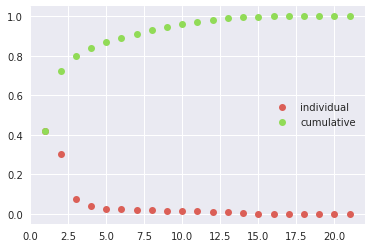

In [34]:
## COMPONENT ANALYSIS
pca = sklearn.decomposition.PCA(n_components=nc).fit(train_X)

fullX = pca.transform(full_X)
trainX = pca.transform(train_X)
testX = pca.transform(test_X)
validateX = pca.transform(validate_X)

evals = pca.explained_variance_ratio_
evals_cs = evals.cumsum()
plt.plot(range(1, nc+1), evals, 'o', label='individual')
plt.plot(range(1, nc+1), evals_cs, 'o', label='cumulative')
plt.legend()
plt.savefig(os.path.join(plot_path, 'PCA_variance_ratio.png'))
plt.show()

In [36]:
## PLOT SAMPLES ALONG THE FIRST 2 PRINCIPAL COMPONENTS
X_full = pd.DataFrame(fullX, columns=['comp_'+str(x) for x in range(1, fullX.shape[1]+1)])
X_full['RUL'] = full['RUL']
X_full['status'] = full['status']

X_train = pd.DataFrame(trainX, columns=['comp_'+str(x) for x in range(1, trainX.shape[1]+1)])
X_train['RUL'] = train['RUL']
X_train['status'] = train['status']

X_test = pd.DataFrame(testX, columns=['comp_'+str(x) for x in range(1, testX.shape[1]+1)])
X_test['RUL'] = test['RUL']
X_test['status'] = test['status']

X_validate = pd.DataFrame(validateX, columns=['comp_'+str(x) for x in range(1, validateX.shape[1]+1)])
X_validate['RUL'] = validate['RUL']
X_validate['status'] = validate['status']

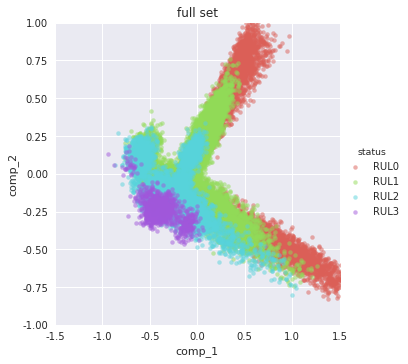

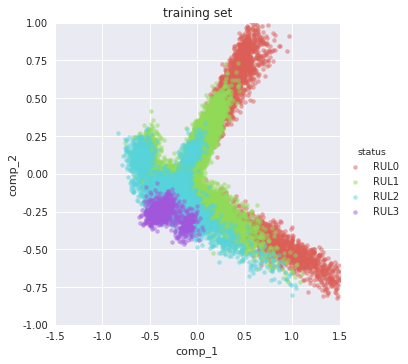

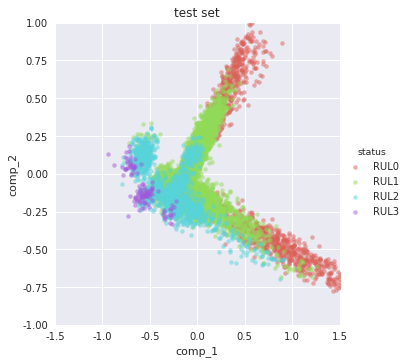

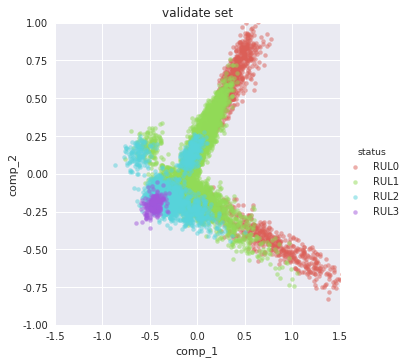

In [37]:
sns.lmplot('comp_1', 'comp_2', hue='status', data=X_full, 
           markers='o', fit_reg=False, scatter_kws={'alpha':0.5, 's':20})
plt.title('full set')
plt.xlim(-1.5, 1.5)
plt.ylim(-1., 1.)
if merge_data:
    plt.savefig(os.path.join(plot_path, 'full_set_merge.png'))
else:
    plt.savefig(os.path.join(plot_path, 'full_set.png'))
plt.show()

sns.lmplot('comp_1', 'comp_2', hue='status', data=X_train, 
           markers='o', fit_reg=False, scatter_kws={'alpha':0.5, 's':20})
plt.title('training set')
plt.xlim(-1.5, 1.5)
plt.ylim(-1., 1.)
if merge_data:
    plt.savefig(os.path.join(plot_path, 'training_set_merge.png'))
else:
    plt.savefig(os.path.join(plot_path, 'training_set.png'))
plt.show()

sns.lmplot('comp_1', 'comp_2', hue='status', data=X_test, 
           markers='o', fit_reg=False, scatter_kws={'alpha':0.5, 's':20})
plt.title('test set')
plt.xlim(-1.5, 1.5)
plt.ylim(-1., 1.)
if merge_data:
    plt.savefig(os.path.join(plot_path, 'test_set_merge.png'))
else:
    plt.savefig(os.path.join(plot_path, 'test_set.png'))
plt.show()

sns.lmplot('comp_1', 'comp_2', hue='status', data=X_validate, 
           markers='o', fit_reg=False, scatter_kws={'alpha':0.5, 's':20})
plt.title('validate set')
plt.xlim(-1.5, 1.5)
plt.ylim(-1., 1.)
if merge_data:
    plt.savefig(os.path.join(plot_path, 'validate_set_merge.png'))
else:
    plt.savefig(os.path.join(plot_path, 'validate_set.png'))
plt.show()

In [38]:
# Save the preprocessed data
X_train['id'] = train['id']
X_train['cycle'] = train['cycle']
X_validate['id'] = validate['id']
X_validate['cycle'] = validate['cycle']
X_test['id'] = test['id']
X_test['cycle'] = test['cycle']

if merge_data:
    X_full.to_csv(os.path.join(data_path, 'full_'+setnumber+'_PC_merge.csv'), index=False)
    X_train.to_csv(os.path.join(data_path, 'train_'+setnumber+'_PC_merge.csv'), index=False)
    X_test.to_csv(os.path.join(data_path, 'test_'+setnumber+'_PC_merge.csv'), index=False)
    X_validate.to_csv(os.path.join(data_path, 'validate_'+setnumber+'_PC_merge.csv'), index=False)
else:
    X_full.to_csv(os.path.join(data_path, 'full_'+setnumber+'_PC.csv'), index=False)
    X_train.to_csv(os.path.join(data_path, 'train_'+setnumber+'_PC.csv'), index=False)
    X_test.to_csv(os.path.join(data_path, 'test_'+setnumber+'_PC.csv'), index=False)
    X_validate.to_csv(os.path.join(data_path, 'validate_'+setnumber+'_PC.csv'), index=False)

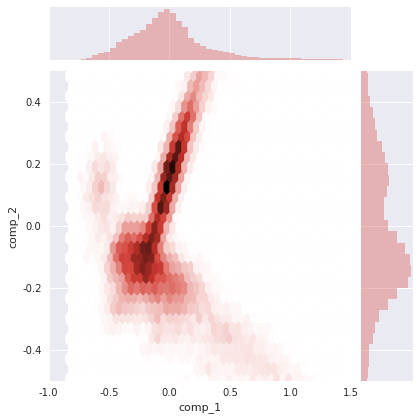

In [39]:
g = sns.jointplot(x='comp_1', y='comp_2', data=X_train, 
                      kind="hex", stat_func=None,
                     xlim=(-1.0, 1.5), ylim=(-0.5, 0.5))
plt.show()

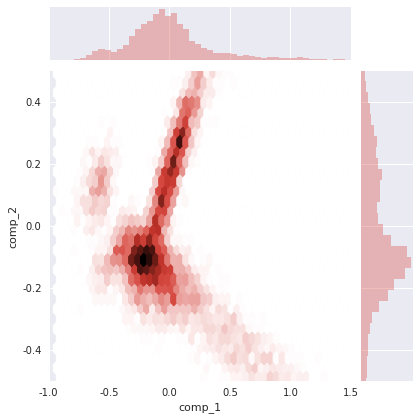

In [40]:
g = sns.jointplot(x='comp_1', y='comp_2', data=X_test, 
                      kind="hex", stat_func=None,
                     xlim=(-1.0, 1.5), ylim=(-0.5, 0.5))
plt.show()


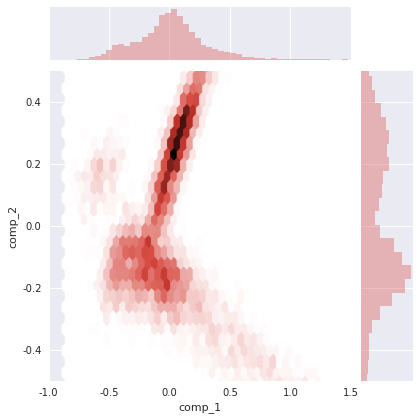

In [41]:
g = sns.jointplot(x='comp_1', y='comp_2', data=X_validate, 
                      kind="hex", stat_func=None,
                     xlim=(-1.0, 1.5), ylim=(-0.5, 0.5))
plt.show()


# # Supervised_classification

In [43]:
import sys
import os.path
from math import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing
import sklearn.neighbors
import sklearn.metrics
import keras.metrics
import keras.models
import keras.layers
import keras.optimizers
import keras.callbacks
import keras.utils.np_utils
import keras.preprocessing.sequence
import supervised_tools as tools
import warnings
warnings.filterwarnings('ignore')
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
data_path = 'data'
if not os.path.exists(data_path):
    os.mkdir(data_path)
plot_path = 'plots'
if not os.path.exists(plot_path):
    os.mkdir(plot_path)    
model_path = 'models'
if not os.path.exists(model_path):
    os.mkdir(model_path)

In [44]:
## Settings
do_knn = True
do_mlp = True
do_hg = True
'''Keep merge_data=True if you have set n_classes (in preprocessing) such that 
there are classes in the test set that do not have instances in the training set'''
merge_data = True 
sn = 3
'''This means that we are using all the features, 
if you want to limit the model to use only a subset of proncipal components, give them to this parameter as a list
The list should always include "id", "cycle", "status" columns'''
usecols = None
setnumber = 'FD00' + str(sn)

## KNN settings
# range of n_neighbors
n_range = np.array(range(1, 20))

## MLP settings
dense_width = 10
dense_depth = 1
dropout = 0.2
bs = 500 #batch size
epochs = 500

In [45]:
X_train, y_train, X_test, y_test, X_validate, y_validate, train, test, validate = \
tools.prepare_data(setnumber, usecols, merge_data=merge_data)

(24906, 21) (8294, 21) (8116, 21)


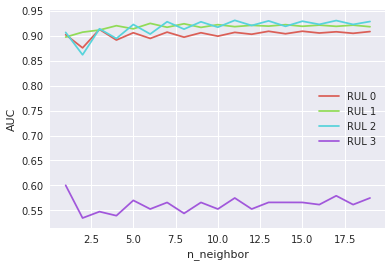

In [46]:
## KNN
if do_knn:
    aucs = np.zeros((len(n_range), y_test.shape[1]))
    for i, n in enumerate(n_range):
        KNN_model = tools.make_knn(n, X_train, y_train, X_test, y_test)
        aucs[i,:], y_pred = tools.make_prediction(KNN_model, X_test, y_test, fig=False)
    colors = ['b', 'g', 'r', 'm']
    plt.figure()
    for l in range(y_test.shape[1]):
        plt.plot(n_range, aucs[:,l], label='RUL %d'%l)
    plt.legend()
    plt.xlabel('n_neighbor')
    plt.ylabel('AUC')
    plt.show()

In [47]:
## MLP
if do_mlp:
    MLP_model = tools.make_mlp(train, X_train, dense_width, dense_depth, dropout)
    MLP_hist = tools.fit_mlp(MLP_model, X_train, y_train, X_validate, y_validate, bs, epochs)
    #MLP_model.save(os.path.join(model_path, 'MLP_model_%s_%d_%d_%.1f.h5'%(setnumber, dense_width, dense_depth, dropout)))

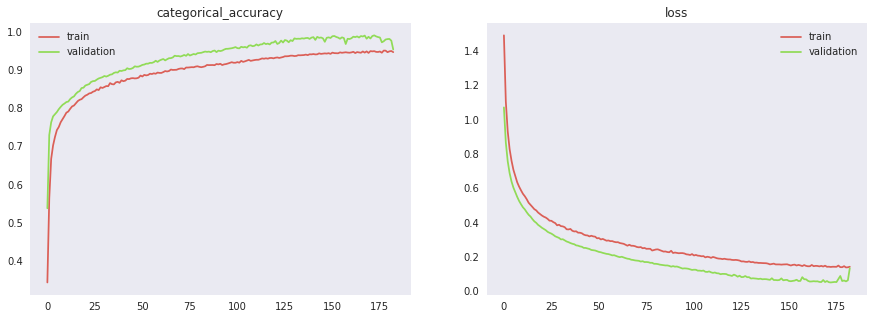

In [48]:
if do_mlp:
    MLP_auc = tools.plot_learning_curve(MLP_hist, setnumber, merge_data=merge_data)

In [49]:
## Hourglass
if do_hg:
    hg_model = tools.make_hourglass(train, X_train, dropout)
    hg_hist = tools.fit_mlp(hg_model, X_train, y_train, X_validate, y_validate, bs, epochs)
    #hg_model.save(os.path.join(model_path, 'hg_model_%s.h5'%(setnumber)))

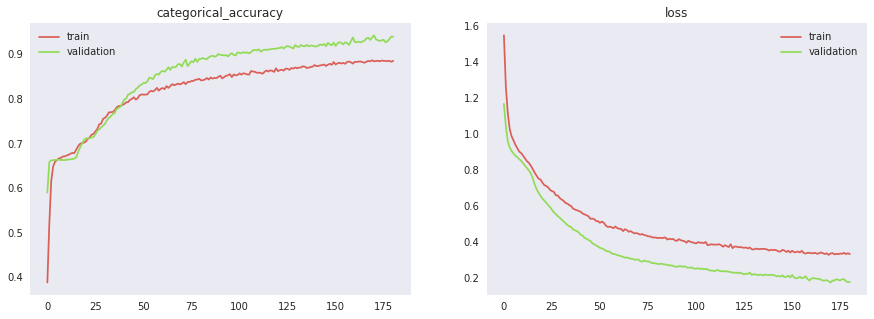

In [50]:
if do_hg:
    hg_auc = tools.plot_learning_curve(hg_hist, setnumber, merge_data)

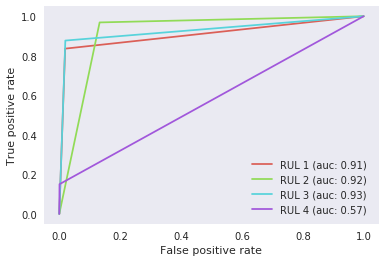

             precision    recall  f1-score   support

          0       0.87      0.84      0.85      1080
          1       0.94      0.97      0.95      5565
          2       0.90      0.88      0.89      1358
          3       0.74      0.15      0.25       113

avg / total       0.92      0.92      0.92      8116



In [51]:
if do_knn:
    aucs, y_pred_knn = tools.make_prediction(KNN_model, X_test, y_test, fig=True)
    y_knn = y_pred_knn
    print (sklearn.metrics.classification_report(y_test, y_knn))
    precision_knn, recall_knn, f1_knn, support_knn = sklearn.metrics.precision_recall_fscore_support(y_test, y_knn)
    y_knn_int = np.array([np.argmax(y_knn[i]) for i in range(len(y_knn))])

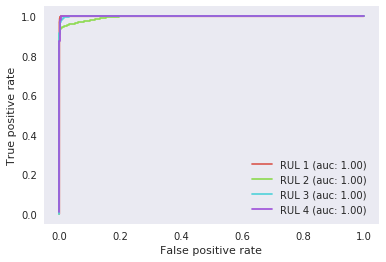

             precision    recall  f1-score   support

          0       0.79      1.00      0.88      1080
          1       0.99      0.95      0.97      5565
          2       0.98      0.97      0.98      1358
          3       0.96      0.84      0.90       113

avg / total       0.96      0.96      0.96      8116



In [52]:
if do_mlp:
    aucs, y_pred_mlp = tools.make_prediction(MLP_model, X_test, y_test, fig=True)
    y_mlp = keras.utils.np_utils.to_categorical(
        np.array([np.argmax(y_pred_mlp[i]) for i in range(len(y_pred_mlp))]),
        num_classes=train.status.nunique())
    print (sklearn.metrics.classification_report(y_test, y_mlp))
    precision_mlp, recall_mlp, f1_mlp, support_mlp = sklearn.metrics.precision_recall_fscore_support(y_test, y_mlp)
    y_mlp_int = np.array([np.argmax(y_mlp[i]) for i in range(len(y_mlp))])

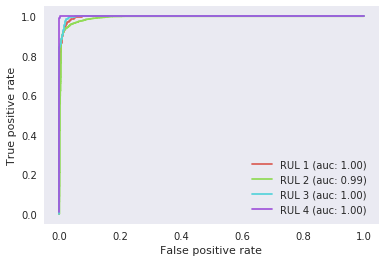

             precision    recall  f1-score   support

          0       0.98      0.75      0.85      1080
          1       0.95      0.99      0.97      5565
          2       0.90      0.98      0.94      1358
          3       0.00      0.00      0.00       113

avg / total       0.93      0.94      0.94      8116



In [53]:
if do_hg:
    aucs, y_pred_hg = tools.make_prediction(hg_model, X_test, y_test, fig=True)
    y_hg = keras.utils.np_utils.to_categorical(
        np.array([np.argmax(y_pred_hg[i]) for i in range(len(y_pred_hg))]), 
        num_classes=train.status.nunique())
    print (sklearn.metrics.classification_report(y_test, y_hg))
    precision_hg, recall_hg, f1_hg, support_hg = sklearn.metrics.precision_recall_fscore_support(y_test, y_hg)
    y_hg_int = np.array([np.argmax(y_hg[i]) for i in range(len(y_hg))])

In [54]:
y_test_int = np.array([np.argmax(y_test[i]) for i in range(len(y_test))])

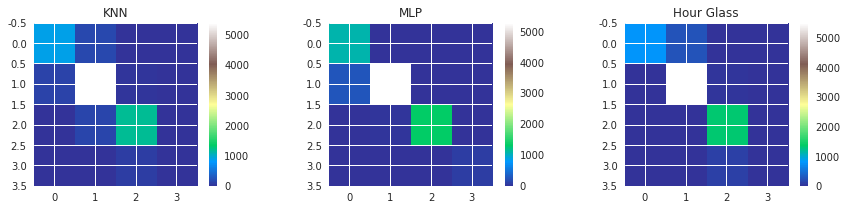

In [55]:
if do_knn and do_mlp and do_hg:
    cmap = 'terrain'
    fig, axs = plt.subplots(1,3, figsize=(15,3))
    axs = axs.flatten()
    cm_knn = axs[0].imshow(sklearn.metrics.confusion_matrix(y_test_int, y_knn_int), cmap=cmap)
    axs[0].set_title('KNN')
    plt.colorbar(mappable=cm_knn, ax=axs[0])
    cm_mlp = axs[1].imshow(sklearn.metrics.confusion_matrix(y_test_int, y_mlp_int), cmap=cmap)
    axs[1].set_title('MLP')
    plt.colorbar(mappable=cm_mlp, ax=axs[1])
    cm_hg = axs[2].imshow(sklearn.metrics.confusion_matrix(y_test_int, y_hg_int), cmap=cmap)
    axs[2].set_title('Hour Glass')
    plt.colorbar(mappable=cm_hg, ax=axs[2])
    plt.show()

# # Unsupervised_classification 

In [56]:
import sys
import os.path
from math import *
import numpy as np
import pandas as pd
import sklearn.preprocessing
import sklearn.decomposition
import sklearn.cross_decomposition
import sklearn.mixture
import sklearn.neighbors
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
current_palette_4 = sns.color_palette("hls", 4)
sns.set_palette(current_palette_4)
import LSTM_tools as tools
import warnings
warnings.filterwarnings('ignore')
data_path = 'data'
plot_path = 'plots'

In [57]:
## Settings
'''Keep merge_data=True if you have set n_classes (in preprocessing) such that 
there are classes in the test set that do not have instances in the training set'''
merge_data = True
'''This means that we are using all the features, 
if you want to limit the model to use only a subset of proncipal components, give them to this parameter as a list
The list should always include "id", "cycle", "status" columns'''
usecols = None
sn = 3
setnumber = 'FD00'+str(sn)

## SVM SETTINGS
outlier_threshold = 0.1


In [58]:
## Read preprocessed data
train, test, validate = tools.read_preprocessed_data(setnumber, usecols, merge_data)
status_labels = train.status.unique()

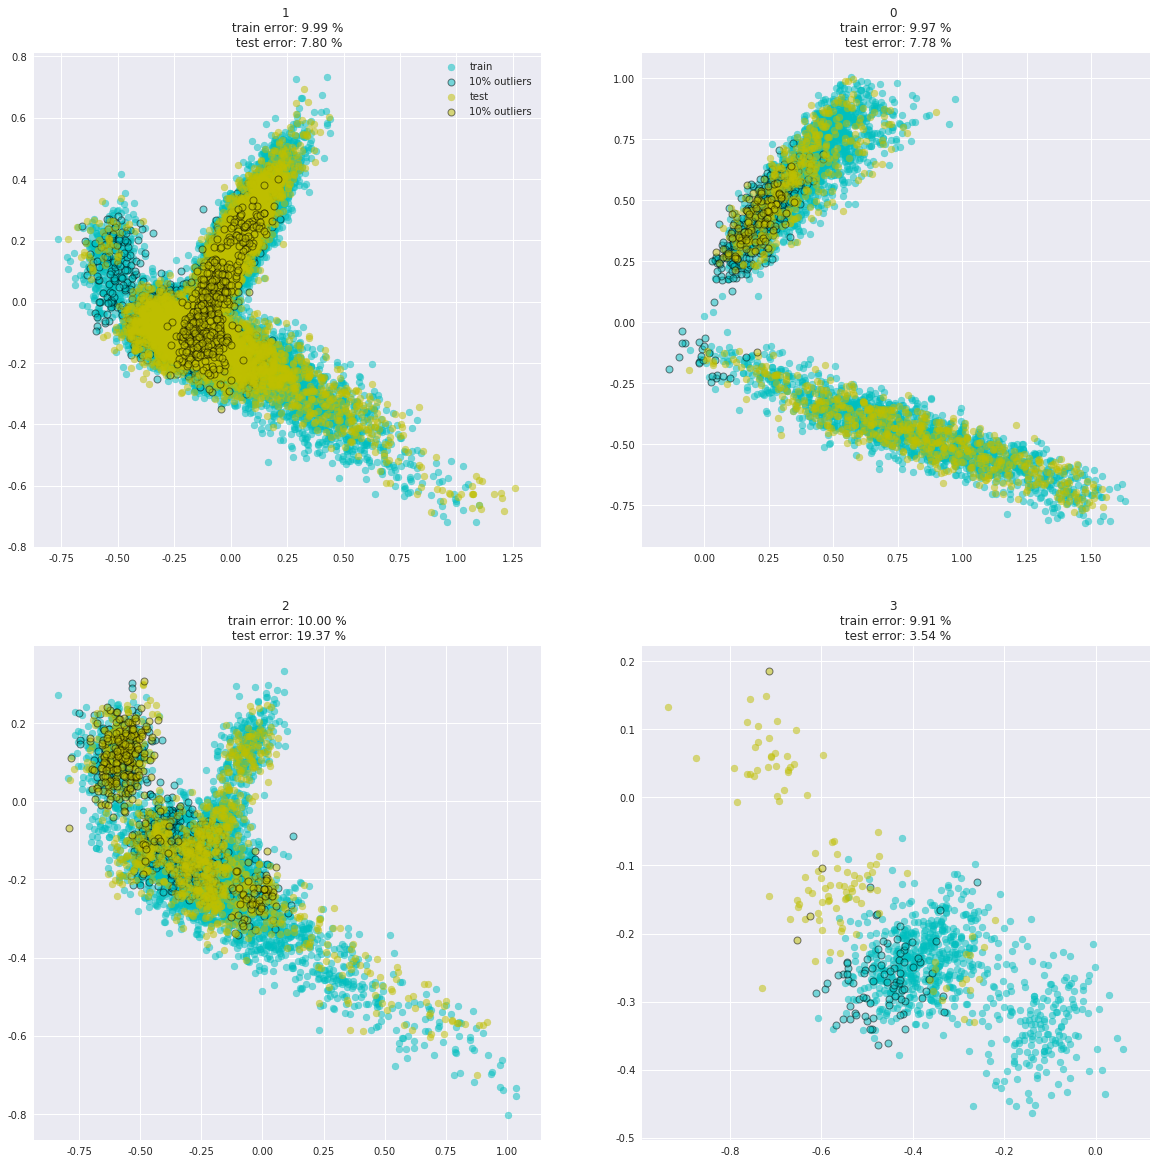

In [59]:
## USE SVM OUTLIER DETECTION
from sklearn import svm
fig, axs = plt.subplots(int(len(status_labels)/2.),2, figsize=(20,20))
axs = axs.flatten()
for i, reference_status in enumerate(status_labels):
    X = train.loc[train.status==reference_status]
    Xtest = test.loc[test.status==reference_status]
    X['status'] = 1
    Xtest['status'] = 1
    clf = svm.OneClassSVM(nu=outlier_threshold, kernel="poly", degree=5).fit(X.values)
    y_pred_train = clf.predict(X)
    y_pred_test = clf.predict(Xtest)
    X['predict'] = y_pred_train
    Xtest['predict'] = y_pred_test
    n_error_train = y_pred_train[y_pred_train == -1].size
    n_error_test = y_pred_test[y_pred_test == -1].size

    train_normal = X.loc[X.predict==1]
    train_outlier = X.loc[X.predict==-1]
    test_normal = Xtest.loc[Xtest.predict==1]
    test_outlier = Xtest.loc[Xtest.predict==-1]

    axs[i].scatter(train_normal.comp_1, train_normal.comp_2, 
                   facecolor='c', label='train', alpha=0.5)
    axs[i].scatter(train_outlier.comp_1, train_outlier.comp_2, 
                   facecolor='c', edgecolor='k', lw=1, 
                   label='%d%% outliers'%(outlier_threshold*100.), alpha=0.5)
    axs[i].scatter(test_normal.comp_1, test_normal.comp_2, 
                   facecolor='y', label='test', alpha=0.5)
    axs[i].scatter(test_outlier.comp_1, test_outlier.comp_2, 
                   facecolor='y', edgecolor='k', lw=1, 
                   label='%d%% outliers'%(outlier_threshold*100.), alpha=0.5)

    axs[i].set_title('%s \n train error: %.2f %% \n test error: %.2f %%'%(reference_status, n_error_train*1. / X.shape[0] * 100., n_error_test*1. / Xtest.shape[0] * 100.))

axs[0].legend()
plt.savefig(os.path.join(plot_path, 'outliers_%d_percent_%s.png'%(outlier_threshold*100, setnumber)))
plt.show()

# # LSTM_classification

In [60]:
import sys
import os.path
import itertools
from math import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing
import sklearn.neighbors
import sklearn.metrics
import keras.optimizers
import keras.callbacks
import keras.utils.np_utils
import keras.preprocessing.sequence
from keras.objectives import categorical_crossentropy
import warnings
warnings.filterwarnings('ignore')
import LSTM_tools as tools
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
data_path = 'data'
if not os.path.exists(data_path):
    os.mkdir(data_path)
plot_path = 'plots'
if not os.path.exists(plot_path):
    os.mkdir(plot_path)    
model_path = 'models'
if not os.path.exists(model_path):
    os.mkdir(model_path)

In [61]:
## Settings
'''Keep merge_data=True if you have set n_classes (in preprocessing) such that 
there are classes in the test set that do not have instances in the training set'''
merge_data = True 
sn = 3
'''This means that we are using all the features, 
if you want to limit the model to use only a subset of proncipal components, give them to this parameter as a list.
The list should always include "id", "cycle", "status" columns'''
usecols = None
setnumber = 'FD00' + str(sn)
data_path = 'data'
plot_path = 'plots'
model_path = 'models'

## LSTM settings
n_in = 60
n_out = 1
dropout = 0.2
bs = 1000 #batch size-Note that smaller batch sizes lead to [considerably] longer training times
epochs = 50
LSTM_units = 8

maxlen: 525
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, 1, 525)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 17088     
_________________________________________________________________
dropout_6 (Dropout)          (None, 8)                 0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 8)                 32        
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 36        
Total params: 17,156
Trainable params: 17,140
Non-trainable params: 16
_________________________________________________________________
None


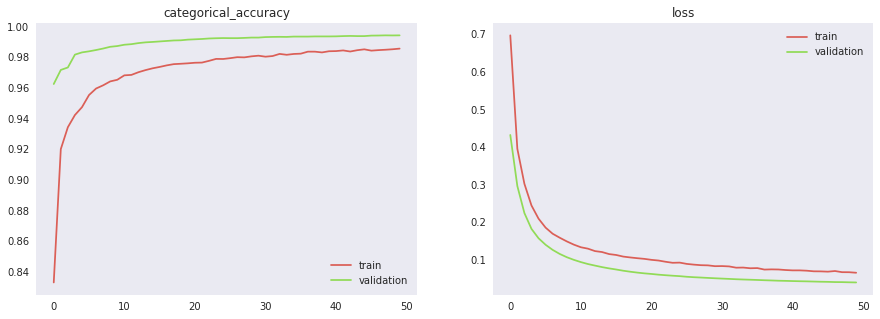

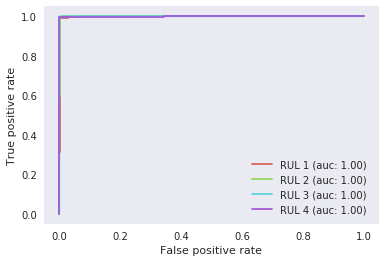

             precision    recall  f1-score   support

          0       0.98      0.97      0.97      1080
          1       0.99      0.99      0.99      3761
          2       0.98      1.00      0.99       861
          3       1.00      1.00      1.00     12898

avg / total       0.99      0.99      0.99     18600



In [62]:
train, test, validate = tools.read_preprocessed_data(setnumber, usecols, merge_data)
X_train, y_train, X_test, y_test, X_validate, y_validate = tools.prepare_data_for_LSTM(train, test, validate, n_in=n_in, n_out=n_out)
y_train_bin = keras.utils.np_utils.to_categorical(y_train)
y_test_bin = keras.utils.np_utils.to_categorical(y_test)
y_validate_bin = keras.utils.np_utils.to_categorical(y_validate)
lw = X_train.shape[1]
n_classes = max(train.status.nunique(), validate.status.nunique())
# create the model
model = keras.models.Sequential()
model.add(keras.layers.Masking(mask_value=-1, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.LSTM(
    LSTM_units,
    input_shape=(X_train.shape[1], X_train.shape[2]),
    unroll=False,
#    return_sequences=True
))
model.add(keras.layers.Dropout(dropout))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(n_classes, activation='softmax'))
sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=[keras.metrics.categorical_accuracy])
print(model.summary())
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(X_train, y_train_bin, epochs=epochs, batch_size=bs,
                    validation_data=(X_validate, y_validate_bin),
                    verbose=0, shuffle=True,
                    callbacks=[early_stopping])
#model.save(os.path.join(model_path, 'LSTM_model_%s_%d_%.1f_nin_%d.h5'%(setnumber, LSTM_units, dropout, n_in)))
tools.plot_learning_curve(history, merge_data)
plt.show()
aucs, y_pred = tools.make_prediction(model, X_test, y_test_bin, fig=True)
target_names = ['class 0', 'class 1', 'class 2', 'class3']
y_pred_bin = keras.utils.np_utils.to_categorical(np.array([np.argmax(y_pred[i]) for i in range(len(y_pred))]),
                                                 num_classes=train.status.nunique())
print (sklearn.metrics.classification_report(y_test_bin, y_pred_bin))